# Graph Neural Networks: Deep Learning para entornos no estructurados.

## Introducción

Este cuaderno forma parte del Trabajo de Fin de Grado *Graph Neural Networks: Deep Learning para entornos no estructurados*, y tiene como propósito mostrar ejemplos prácticos de algunos de los modelos estudiados a lo largo del trabajo. A través de una serie de experimentos, se busca ilustrar el funcionamiento y utilidad de estos modelos en problemas de clasificación y predicción de relaciones.

Si bien aquí se presenta el código y su ejecución, los fundamentos teóricos, motivación y análisis detallado de resultados se encuentran explicados en la memoria principal del proyecto.

## Contenido del documento

El documento está organizado en tres partes, cada una centrada en un enfoque concreto del aprendizaje en grafos:

1. Clasificación de nodos con un modelo convolucional (GCN).
2. Clasificación de nodos con un modelo de atención espacial (GAT).
3. Predicción de enlaces con un modelo convolucional (GCN).

Cada apartado incluirá el planteamiento del modelo, su entrenamiento y las métricas obtenidas. Se utilizará el conjunto de datos de redes de citas *Planetoid Cora Dataset* para los tres experimentos. En este conjunto de datos, los nodos son documentos con vectores de características de 1433 dimensiones y las aristas son enlaces de citas entre artículos de investigación.

## Entorno de ejecución

Este notebook está diseñado para funcionar de forma independiente, sin necesidad de crear un entorno virtual específico. Las dependencias necesarias se instalan directamente mediante `pip` en la primera celda, lo que facilita su ejecución en plataformas como Google Colab o desde cualquier máquina con Python instalado.

Esta decisión busca simplificar el uso y evitar conflictos con otros entornos del proyecto, como el entorno `antifraud-env` usado en la implementación principal de GTAN.


## Instalación de librerías (opcional)

Si estás ejecutando este notebook por primera vez en un entorno sin estas librerías instaladas, como Google Colab, puedes usar la siguiente celda para instalar las librerías necesarias. Si ya las tienes instaladas, puedes omitirla.

In [2]:
%pip install torch torchvision torchaudio
%pip install torch-geometric torch-scatter torch-sparse
%pip install matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Carga del dataset Cora
Usamos el dataset Cora incluido en PyTorch Geometric a través de `Planetoid`. El conjunto de datos **Cora** contiene información sobre publicaciones científicas en forma de grafo. Consta de:

- **2708 nodos**, donde cada nodo representa un artículo.
- **10.556 aristas**, que indican relaciones de citación entre artículos.
- **1433 características** por nodo. Es decir, que cada nodo está representado por un vector binario de 1433 dimensiones que reflejan la presencia de ciertos términos en el documento.
- **7 clases** correspondientes a categorías temáticas del artículo.

Además, el objeto cargado incluye máscaras de entrenamiento, validación y test (`train_mask`, `val_mask`, `test_mask`), que permiten entrenar y evaluar el modelo sin necesidad de particionar manualmente los datos.

In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


## Experimento 1: Clasificación de nodos con un modelo convolucional (GCN)
Esta implementación se basa en el artículo publicado por [DataCamp](https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial), donde se introduce el uso de GNNs para tareas de clasificación de nodos con el dataset **Cora**. Se ha adaptado el código original para su integración en este proyecto.

### Arquitectura del modelo GCN

El modelo GCN utilizado se compone de **dos capas GCNConv**, una función de activación **ReLU** entre capas y una capa de abandono (*dropout*) con una tasa del **50%** para regularización. El número de unidades ocultas se ha fijado en **16 canales**.

La operación principal en cada capa de una GCN se describe mediante la siguiente ecuación:

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell+1)} \sum_{w \in \mathcal{N}(v) \cup \{v\}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

donde:
- $\mathbf{x}_v^{(\ell)}$ representa las características del nodo $v$ en la capa $\ell$,
- $\mathcal{N}(v)$ es el conjunto de vecinos del nodo $v$,
- $c_{w,v}$ es un factor de normalización que depende del grado de los nodos $w$ y $v$,
- $\mathbf{W}^{(\ell+1)}$ es una matriz de pesos entrenable de la capa $\ell+1$.

Esta operación permite que cada nodo actualice su representación a partir de las representaciones de sus vecinos, incorporando así la estructura del grafo en el aprendizaje.


In [2]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


### Visualización de la red GCN no entrenada

Vamos a visualizar las incrustaciones o representaciones (embeddings) de los nodos de una red GCN no entrenada en el embedding space. Para ello, utilizaremos la técnica de reducción de dimensionalidad **T-SNE**, proporcionada por `sklearn.manifold.TSNE`, junto con `matplotlib.pyplot` para generar un gráfico de dispersión 2D.

Esto nos permitirá representar las características de los nodos (inicialmente de 1433 dimensiones) en un espacio bidimensional, facilitando su análisis visual.

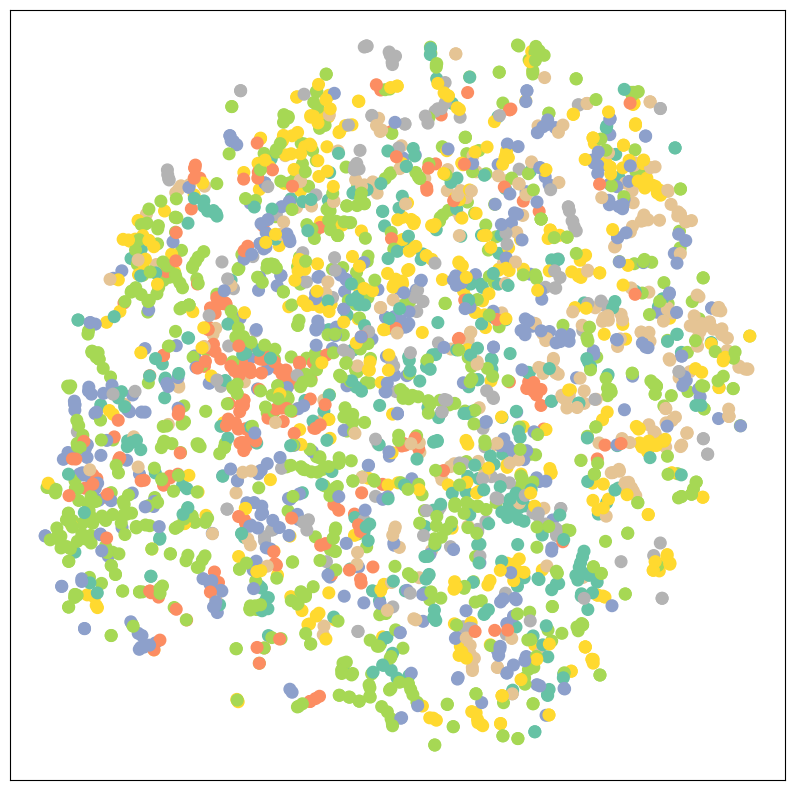

In [3]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Entrenamiento del modelo GCN

El modelo GCN será entrenado durante 100 épocas utilizando el optimizador **Adam** y la función de **pérdida de entropía cruzada** como criterio de evaluación.

### Proceso de entrenamiento

Durante cada época de entrenamiento se realiza la siguiente secuencia de pasos:

1. Se reinician los gradientes del modelo.
2. Se ejecuta una pasada hacia adelante (forward pass) para obtener las predicciones.
3. Se calcula la pérdida únicamente sobre los nodos incluidos en el conjunto de entrenamiento.
4. Se realiza la retropropagación del error y se actualizan los pesos del modelo.

### Proceso de evaluación

Al evaluar el modelo, se siguen estos pasos:

1. Se generan las predicciones para cada nodo.
2. Se determina la clase más probable asignada por el modelo para cada uno.
3. Se comparan las etiquetas predichas con las verdaderas en los nodos del conjunto de prueba.
4. Se calcula la precisión como la proporción de nodos correctamente clasificados respecto al total evaluado.


In [4]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    pred = out.argmax(dim=1)
    correct = pred[data.train_mask] == data.y[data.train_mask]
    acc = int(correct.sum()) / int(data.train_mask.sum())

    return loss.item(), acc

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

# Inicializamos listas para guardar métricas
train_losses = []
train_accuracies = []

for epoch in range(1, 101):
    loss, acc = train()
    train_losses.append(loss)
    train_accuracies.append(acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {acc:.4f}')


Epoch: 001, Loss: 1.9465, Train Acc: 0.1286
Epoch: 002, Loss: 1.9419, Train Acc: 0.2357
Epoch: 003, Loss: 1.9363, Train Acc: 0.4286
Epoch: 004, Loss: 1.9290, Train Acc: 0.4929
Epoch: 005, Loss: 1.9199, Train Acc: 0.4929
Epoch: 006, Loss: 1.9140, Train Acc: 0.4357
Epoch: 007, Loss: 1.9079, Train Acc: 0.4786
Epoch: 008, Loss: 1.8992, Train Acc: 0.5500
Epoch: 009, Loss: 1.8876, Train Acc: 0.5357
Epoch: 010, Loss: 1.8764, Train Acc: 0.6000
Epoch: 011, Loss: 1.8656, Train Acc: 0.5786
Epoch: 012, Loss: 1.8626, Train Acc: 0.5286
Epoch: 013, Loss: 1.8460, Train Acc: 0.6286
Epoch: 014, Loss: 1.8329, Train Acc: 0.6143
Epoch: 015, Loss: 1.8225, Train Acc: 0.6429
Epoch: 016, Loss: 1.8167, Train Acc: 0.6000
Epoch: 017, Loss: 1.7995, Train Acc: 0.6857
Epoch: 018, Loss: 1.7878, Train Acc: 0.6714
Epoch: 019, Loss: 1.7716, Train Acc: 0.7143
Epoch: 020, Loss: 1.7568, Train Acc: 0.7571
Epoch: 021, Loss: 1.7563, Train Acc: 0.7071
Epoch: 022, Loss: 1.7342, Train Acc: 0.7643
Epoch: 023, Loss: 1.7092, Train 

### Evaluación del modelo
Ahora evaluaremos el modelo en un conjunto de datos no visto utilizando la función de prueba. Como podemos ver, obtuvimos una precisión del 81,1%.  

In [5]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8110


### Visualización del modelo una vez entrenado

Una vez completado el entrenamiento del modelo GCN, vamos a visualizar las incrustaciones (embeddings) generadas por la última capa para comprobar visualmente cómo se han agrupado los nodos en función de sus categorías. Como podemos ver, el modelo entrenado ha producido una mejor agrupación de nodos para la misma categoría.


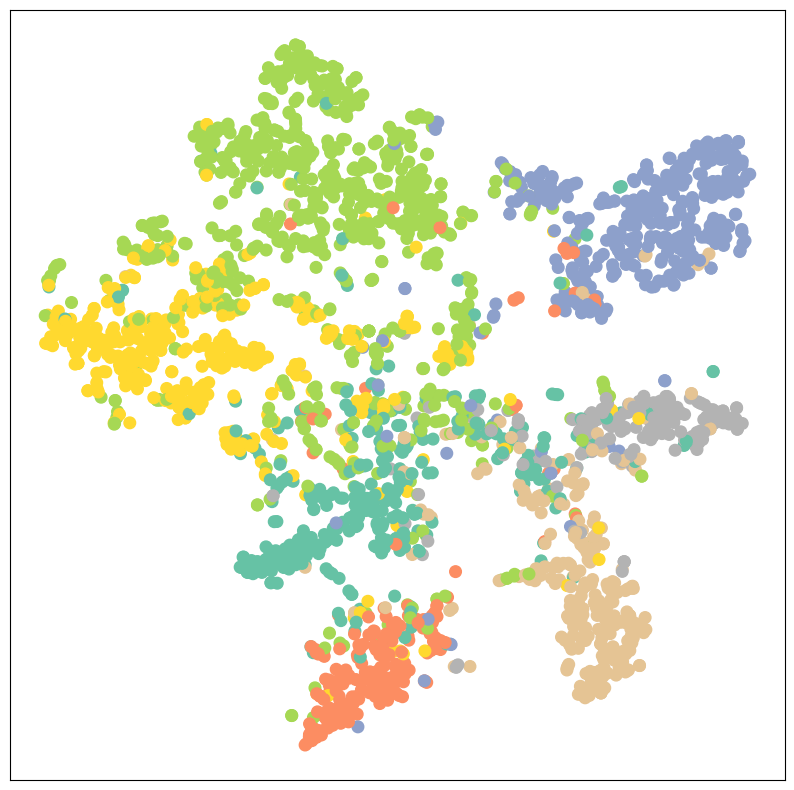

In [8]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### Evolución de la pérdida y la precisión

Para analizar el comportamiento del modelo GCN durante el proceso de entrenamiento, se han registrado los valores de la función de pérdida (loss) y la precisión (accuracy) en cada época. A partir de estos valores, se ha generado una gráfica que muestra la evolución de ambas métricas a lo largo de las iteraciones.


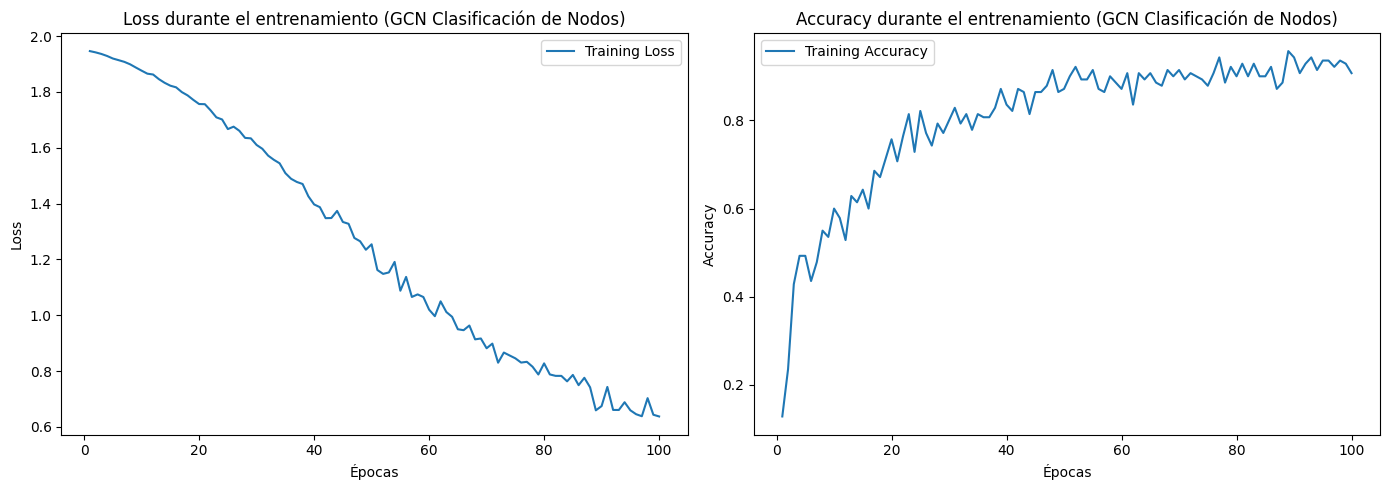

In [6]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, train_accuracies, val_losses=None, val_accuracies=None, title_suffix=''):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(14, 5))

    # Plot de Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    if val_losses:
        plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss durante el entrenamiento ' + title_suffix)
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    # Plot de Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    if val_accuracies:
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy durante el entrenamiento ' + title_suffix)
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(train_losses, train_accuracies, title_suffix='(GCN Clasificación de Nodos)')

# Experimento 2: Clasificación de nodos con un modelo de atención espacial (GAT).
Esta implementación se basa en el artículo publicado por [DataCamp](https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial), donde se introduce el uso de GNNs para tareas de clasificación de nodos con el dataset **Cora**. Se ha adaptado el código original para su integración en este proyecto.

### Entrenamiento del modelo GATConv

En esta segunda implementación sustituiremos las capas `GCNConv` utilizadas previamente por `GATConv` (Graph Attention Networks). Estas capas basadas en atención permiten asignar pesos distintos a los nodos vecinos, mitigando las limitaciones de los modelos convolucionales y mejorando la capacidad expresiva del modelo.

GAT introduce mecanismos de atención multi-cabeza, lo que permite al modelo aprender múltiples representaciones en paralelo. En este caso concreto, utilizaremos:

- **8 cabezas de atención** en la primera capa
- **1 cabeza de atención** en la segunda capa

Además, fijaremos:

- **Tasa de abandono (dropout):** 0.6  
- **Número de canales ocultos:** 8  
- **Tasa de aprendizaje:** 0.005

La función de evaluación también ha sido modificada para calcular la precisión de forma diferenciada para las máscaras de validación y test (`val_mask`, `test_mask`). Esto nos permitirá visualizar de forma separada el rendimiento del modelo durante el entrenamiento y comprobar cómo evoluciona en cada conjunto de datos.


In [8]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
val_accuracies = []
test_accuracies = []

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    pred = out.argmax(dim=1)
    correct = pred[data.train_mask] == data.y[data.train_mask]
    acc = int(correct.sum()) / int(data.train_mask.sum())
    
    return loss.item(), acc


def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc


for epoch in range(1, 101):
    loss, train_acc = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    
    train_losses.append(loss)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0245, Train Acc: 0.0143, Val Acc: 0.1700, Test Acc: 0.2040
Epoch: 002, Loss: 3.9922, Train Acc: 0.2429, Val Acc: 0.2800, Test Acc: 0.3010
Epoch: 003, Loss: 3.9547, Train Acc: 0.4286, Val Acc: 0.3480, Test Acc: 0.3720
Epoch: 004, Loss: 3.9151, Train Acc: 0.4857, Val Acc: 0.3960, Test Acc: 0.4480
Epoch: 005, Loss: 3.8637, Train Acc: 0.4500, Val Acc: 0.4300, Test Acc: 0.4750
Epoch: 006, Loss: 3.8053, Train Acc: 0.5500, Val Acc: 0.4280, Test Acc: 0.4850
Epoch: 007, Loss: 3.7579, Train Acc: 0.4643, Val Acc: 0.4300, Test Acc: 0.4770
Epoch: 008, Loss: 3.6782, Train Acc: 0.4571, Val Acc: 0.4260, Test Acc: 0.4620
Epoch: 009, Loss: 3.5984, Train Acc: 0.4500, Val Acc: 0.4220, Test Acc: 0.4410
Epoch: 010, Loss: 3.5145, Train Acc: 0.5143, Val Acc: 0.4120, Test Acc: 0.4250
Epoch: 011, Loss: 3.4376, Train Acc: 0.4429, Val Acc: 0.3980, Test Acc: 0.4030
Epoch: 012, Loss: 3.3417, Train Acc: 0.4071, Val Acc

Como podemos observar, nuestro modelo no obtuvo mejores resultados que GCNConv. Requiere la optimización de hiperparámetros o más épocas para lograr mejores resultados. A continuación, visualizaremos la agrupación de nodos del modelo GATConv.

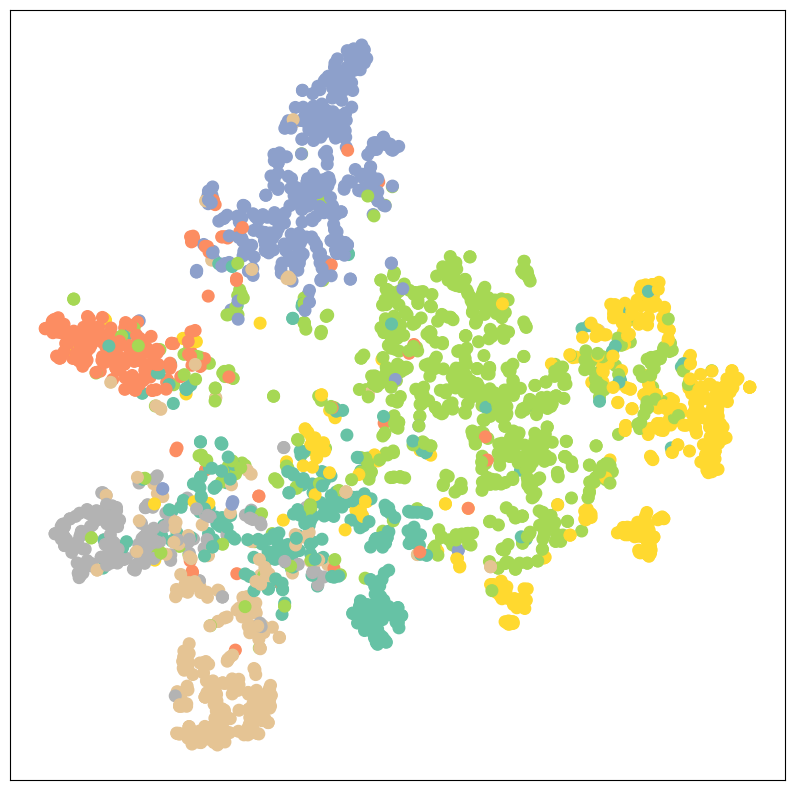

In [9]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### Evolución de la pérdida y la precisión

La figura resultante muestra la evolución de ambas métricas a lo largo del entrenamiento. Se observa una disminución progresiva de la pérdida y un aumento de la precisión sobre los datos de entrenamiento, lo que indica que el modelo es capaz de aprender representaciones útiles para la tarea planteada.

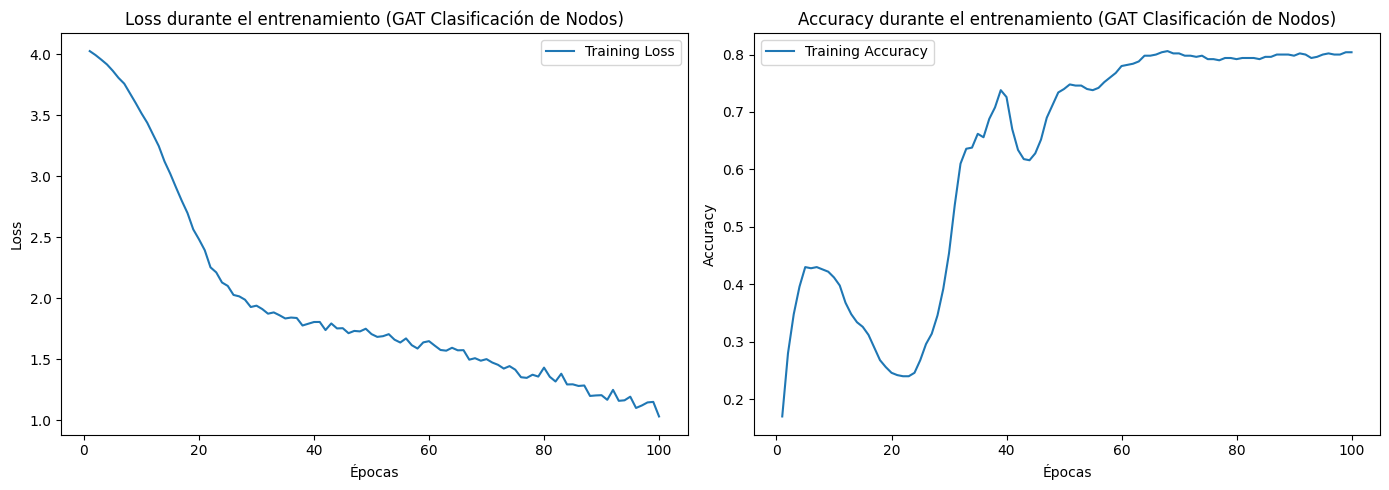

In [10]:
plot_training_curves(train_losses, val_accuracies, title_suffix='(GAT Clasificación de Nodos)')

# Experimento 3: Predicción de enlaces con un modelo convolucional (GCN).
Esta implementación se basa en el artículo publicado por [Medium](https://medium.com/data-science/graph-neural-networks-with-pyg-on-node-classification-link-prediction-and-anomaly-detection-14aa38fe1275#:~:text=node%20classification%20problem.-,Link%20Prediction,connections%20based%20on%20network%20data.), donde se implementan GNNs para tareas de predicción de enlaces con el dataset **Cora**. Se ha adaptado el código original para su integración en este proyecto.

### Preparación del dataset

En este experimento se reutiliza el conjunto de datos **Cora**, adaptándolo específicamente para una tarea de predicción de enlaces. Esto requiere ocultar una parte de las aristas reales del grafo (enlaces positivos) y generar ejemplos negativos (pares de nodos no conectados) que servirán como ejemplos de no-enlace.

La división del grafo se realiza mediante `RandomLinkSplit`, una herramienta de PyTorch Geometric que:

- Divide automáticamente el conjunto de enlaces en subconjuntos de entrenamiento, validación y prueba.
- Añade enlaces negativos (nodos que no están conectados) para cada subconjunto.

El resultado son tres grafos: `train_data`, `val_data` y `test_data`, que contienen las siguientes estructuras útiles:

- `x`: características de los nodos.
- `edge_index`: aristas visibles (solo en `train_data`).
- `pos_edge_label_index` y `neg_edge_label_index`: enlaces positivos y negativos, respectivamente.
- `edge_label`: etiquetas binarias para tareas de clasificación de enlaces.

Esta división permite entrenar al modelo sobre enlaces conocidos y evaluarlo sobre enlaces ocultos, tanto positivos como negativos, de forma robusta y controlada.



In [11]:
from torch_geometric.transforms import RandomLinkSplit
# Split para validación y test
transform = RandomLinkSplit(is_undirected=True, split_labels=True, add_negative_train_samples=True)
train_data, val_data, test_data = transform(data)

### Definición del modelo GCN para predicción de enlaces

Al igual que anteriormente, queremos que el modelo genere incrustaciones (embeddings) para cada nodo. De esta forma, los nodos que deberían estar conectados tendrán representaciones vectoriales similares. Esto se utilizará posteriormente para predecir la existencia de enlaces.

El modelo constará de dos capas `GCNConv`, similares a las usadas en clasificación, pero la salida no será directamente pasada por una capa lineal ni softmax, sino que será usada para evaluar enlaces entre nodos.


In [12]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNLinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1) # Producto escalar entre pares de nodos

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t() # Devuelve todas las predicciones posibles para todo el grafo


### Inicialización del modelo

Una vez definido el modelo `GCNLinkPredictor`, lo instanciamos con los parámetros adecuados y preparamos el proceso de entrenamiento. Este modelo se encargará de generar representaciones vectoriales para los nodos a partir de la estructura del grafo de entrenamiento (`train_data.edge_index`). A partir de estas representaciones, se estimará la probabilidad de que un par de nodos esté conectado o no, usando productos escalares.

En el entrenamiento, utilizamos:

- El optimizador **Adam**, con una tasa de aprendizaje (`learning rate`) de 0.01.
- La función de pérdida **binaria con logits** (`BCEWithLogitsLoss`), adecuada para tareas de clasificación binaria.

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCNLinkPredictor(
    in_channels=train_data.x.size(-1),
    hidden_channels=64
).to(device)

x = train_data.x.to(device)
edge_index = train_data.edge_index.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

### Función de entrenamiento

Durante cada época de entrenamiento, se hace lo siguiente:

1. Se genera un conjunto de embeddings (`z`) para todos los nodos usando el grafo parcial de entrenamiento.
2. Se calculan predicciones de enlaces positivos (pares de nodos que están conectados) y negativos (pares no conectados).
3. Se concatenan ambos y se evalúan mediante una función de pérdida binaria (`BCEWithLogitsLoss`).
4. Se actualizan los parámetros del modelo con retropropagación.

Esta función entrena el modelo durante una única época y devuelve el valor de la pérdida.


In [14]:
def get_link_labels(pos_edge_index, neg_edge_index):
    num_links = pos_edge_index.size(1) + neg_edge_index.size(1)
    labels = torch.zeros(num_links, device=device)
    labels[:pos_edge_index.size(1)] = 1
    return labels

def train():
    model.train()
    optimizer.zero_grad()

    z = model.encode(x, edge_index)

    pos_edge_index = train_data.pos_edge_label_index.to(device)
    neg_edge_index = train_data.neg_edge_label_index.to(device)

    pos_pred = model.decode(z, pos_edge_index)
    neg_pred = model.decode(z, neg_edge_index)

    pred = torch.cat([pos_pred, neg_pred], dim=0)
    labels = get_link_labels(pos_edge_index, neg_edge_index)

    loss = criterion(pred, labels)
    loss.backward()
    optimizer.step()
    return loss


### Función de evaluación

Para evaluar el modelo en las tareas de validación y prueba, utilizamos dos métricas comunes en clasificación binaria:

- **AUC (Area Under the Curve):** mide la capacidad del modelo para distinguir entre enlaces reales y falsos.
- **Average Precision (AP):** precisión promedio sobre el ranking de predicciones.

Se generan las predicciones de enlace para los conjuntos de validación y prueba y se comparan con sus etiquetas reales.


In [15]:
from sklearn.metrics import average_precision_score, roc_auc_score

@torch.no_grad()
def test(pos_edge_index, neg_edge_index, edge_index):
    model.eval()
    z = model.encode(x, edge_index)

    pos_pred = model.decode(z, pos_edge_index)
    neg_pred = model.decode(z, neg_edge_index)

    pred = torch.cat([pos_pred, neg_pred], dim=0)
    labels = get_link_labels(pos_edge_index, neg_edge_index)

    auc = roc_auc_score(labels.cpu(), pred.cpu())
    ap = average_precision_score(labels.cpu(), pred.cpu())
    return auc, ap

### Entrenamiento del modelo

En este bloque se entrena el modelo durante 100 épocas. Durante el proceso:

- Se calcula y muestra el valor de la pérdida de entrenamiento.
- Se evalúa el rendimiento del modelo sobre los conjuntos de validación y prueba utilizando AUC y AP.
- Estas métricas permiten medir cómo mejora la capacidad del modelo para distinguir enlaces reales y falsos a lo largo del entrenamiento.


In [19]:
train_losses = []
val_aucs = []
val_aps = []

for epoch in range(1, 101):
    loss = train()
    val_auc, val_ap = test(val_data.pos_edge_label_index.to(device), 
                            val_data.neg_edge_label_index.to(device), 
                            train_data.edge_index.to(device))
    
    test_auc, test_ap = test(test_data.pos_edge_label_index.to(device), 
                             test_data.neg_edge_label_index.to(device), 
                             train_data.edge_index.to(device))

    train_losses.append(float(loss))
    val_aucs.append(float(val_auc))
    val_aps.append(float(val_ap))
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}, '
            f'Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')


Epoch: 001, Loss: 0.0061, Val AUC: 0.7150, Val AP: 0.7234, Test AUC: 0.7153, Test AP: 0.7214
Epoch: 002, Loss: 0.0059, Val AUC: 0.7150, Val AP: 0.7233, Test AUC: 0.7153, Test AP: 0.7215
Epoch: 003, Loss: 0.0057, Val AUC: 0.7151, Val AP: 0.7234, Test AUC: 0.7153, Test AP: 0.7216
Epoch: 004, Loss: 0.0056, Val AUC: 0.7152, Val AP: 0.7236, Test AUC: 0.7154, Test AP: 0.7217
Epoch: 005, Loss: 0.0054, Val AUC: 0.7152, Val AP: 0.7237, Test AUC: 0.7155, Test AP: 0.7218
Epoch: 006, Loss: 0.0052, Val AUC: 0.7153, Val AP: 0.7237, Test AUC: 0.7155, Test AP: 0.7219
Epoch: 007, Loss: 0.0051, Val AUC: 0.7153, Val AP: 0.7237, Test AUC: 0.7155, Test AP: 0.7219
Epoch: 008, Loss: 0.0049, Val AUC: 0.7154, Val AP: 0.7238, Test AUC: 0.7155, Test AP: 0.7219
Epoch: 009, Loss: 0.0048, Val AUC: 0.7156, Val AP: 0.7239, Test AUC: 0.7156, Test AP: 0.7220
Epoch: 010, Loss: 0.0047, Val AUC: 0.7157, Val AP: 0.7240, Test AUC: 0.7156, Test AP: 0.7221
Epoch: 011, Loss: 0.0045, Val AUC: 0.7158, Val AP: 0.7241, Test AUC: 0

### Interpretación de los resultados

Tras completar las 100 épocas de entrenamiento, el modelo ha alcanzado unas métricas (AUC y AP) que se han mantenido en torno a valores de 0.72–0.73, lo que indica una capacidad significativa del modelo para identificar correctamente las conexiones entre nodos y distinguirlas de las falsas.

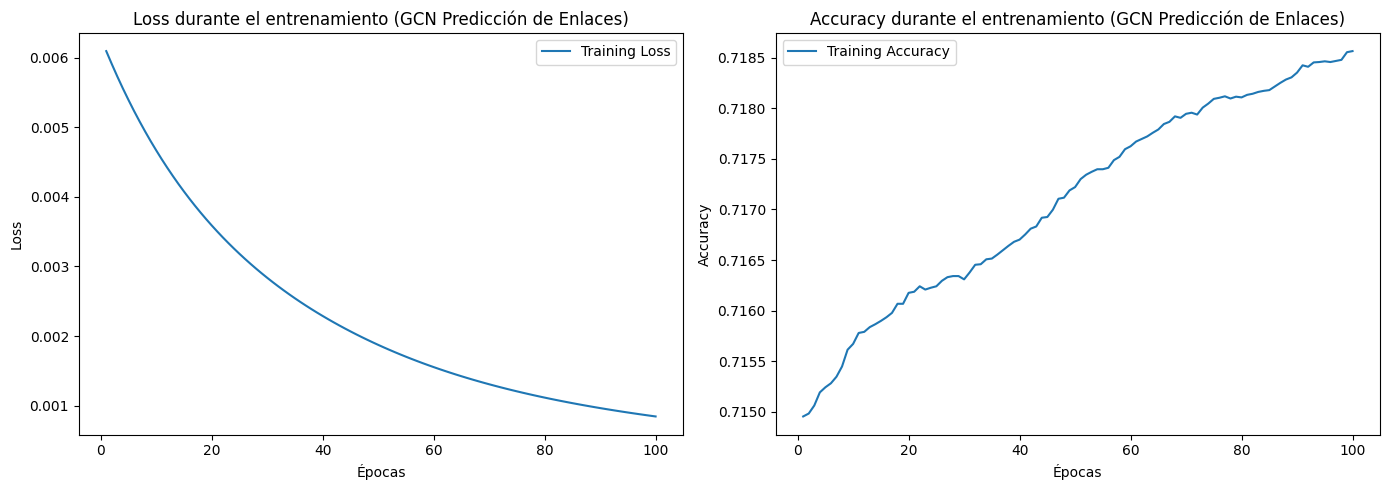

In [20]:
plot_training_curves(train_losses, val_aucs, title_suffix='(GCN Predicción de Enlaces)')